<a href="https://colab.research.google.com/github/JinseoWoo/geo_ML/blob/main/geo_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요 라이브러리 import

In [17]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    !pip install  bayesian-optimization
except:
    pass

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=98ea513ddc277b0476e22e52822938b69227c2e6244b76d65f62689bc7f4e3ad
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


!conda install -c conda-forge bayesian-optimization --y

In [18]:
import pandas as pd                                          #데이터 분석 라이브러리
from sklearn.decomposition import PCA                        #주성분 분석 라이브러리
import numpy as np                                           # 계산 라이브러리
from sklearn.preprocessing import MinMaxScaler, StandardScaler    # scale 라이브러리

from sklearn.model_selection import train_test_split         # 데이터 분할 라이브러리
from sklearn.model_selection import cross_validate           # Kfold 라이브러리
from sklearn.model_selection import cross_val_score          # Kfold 라이브러리
from sklearn.model_selection import StratifiedKFold          # Kfold 라이브러리


from sklearn.neighbors import KNeighborsClassifier           # KNN 라이브러리
from sklearn.svm import SVC                                  # SVM Classifier 라이브러리
from sklearn.tree import DecisionTreeClassifier              # 결정나무분류 라이브러리
from sklearn.linear_model import LogisticRegression          # 로지스틱 회귀 라이브러리
from sklearn.ensemble import RandomForestClassifier          # 랜덤 포레스트 라이브러리
from bayes_opt import BayesianOptimization                   # 베이시안 라이브러리   


from sklearn.metrics import make_scorer                      # 평가용 라이브러리
from sklearn.metrics import f1_score                         # f1  라이브러리
from sklearn.metrics import accuracy_score                   # accuracy 라이브러리 



import matplotlib.pyplot as plt                              # 그래프 라이브러리
from sklearn.ensemble import VotingClassifier                # 보팅 앙상블 라이브러리
import seaborn as sns                                        # boxplot 을 위한 라이브러리
import joblib

# data 불러오기

In [5]:
from google.colab import files
uploaded = files.upload()

Saving geo_training_seq_data.csv to geo_training_seq_data.csv


In [6]:
#import pandas as pd
import io
File = pd.read_csv(io.BytesIO(uploaded['geo_training_seq_data.csv']))

In [ ]:
#File = pd.read_csv("../../Data/final_data/training/geo_data/geo_training_seq_data.csv") # 데이터 불러오기

In [7]:
Floodfile = File.drop(['Unnamed: 0','FLOOD'], axis = 1)  # 필요 독립변수
Floodclass = File['FLOOD']                                            # 종속 변수 

In [8]:
Floodfile

,PUMP_RATIO,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight,F_WEIGHT
0,4.115226e-07,0.104348,0.467342,0.599952,0.045968,0.075019
1,4.115226e-07,0.208696,0.467342,0.599952,0.045968,0.075019
2,4.115226e-07,0.259722,0.467342,0.599952,0.045968,0.075019
3,4.115226e-07,0.010870,0.467342,2.699784,0.072218,0.075019
4,4.115226e-07,0.108696,0.467342,2.699784,0.072218,0.075019
...,...,...,...,...,...,...
791,1.364381e-08,0.573248,1.156156,7.040000,115.950324,0.016667
792,1.364381e-08,0.573248,1.156156,21.608643,13.159136,0.016667
793,1.364381e-08,0.573248,1.156156,12.147570,0.066817,0.016667
794,1.364381e-08,0.573248,1.156156,21.608643,0.061794,0.016667


# minmaxscaler
## data scale 과정

In [9]:
scaler = MinMaxScaler()
scaler.fit(Floodfile)
Floodfile = scaler.transform(Floodfile)  # data sclae 과정 -> minmaxscaler 를 통해 0~1의 값으로 변환

# PCA

In [10]:
pca = PCA(n_components=4)  # 주성분 분석 후 -> 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(Floodfile)  
Floodfile = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])
# pca를 통해 나온 4가지 주성분을 독립변수로 사용하도록 데이터 변형

In [11]:
Floodfile

,principal component1,principal component2,principal component3,principal component4
0,0.063927,-0.681744,0.053284,0.082002
1,0.058611,-0.630972,0.127358,-0.069406
2,0.056012,-0.606144,0.163581,-0.143445
3,0.039158,-0.683262,0.053191,0.266411
4,0.034175,-0.635663,0.122636,0.124467
...,...,...,...,...
791,0.025624,0.696675,0.074157,-0.569671
792,-0.171061,0.993761,0.527883,-0.238038
793,-0.036974,0.794668,0.228558,-0.458647
794,-0.170018,0.992751,0.527118,-0.238898


# data split
## 8 : 2 으로 training 과 test 구분

In [12]:
x_train, x_test, y_train, y_test = train_test_split(Floodfile, Floodclass , test_size=0.2, random_state=400)

# BayesianOptimization

In [13]:
skfolds=StratifiedKFold(n_splits=5, random_state=400 ,shuffle = True)

# 베이지안최적화과정에서 Kfold 를 사용하기위해 설정

## KNN

In [19]:
KNN_search_point = {'k': (3,20), 'leaf': (1,30)}  # 각 옵션들의 범위를 정해줌

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all=[]

def KNN_opt(k,leaf):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):

        x_skftrain, x_val = x_train.values[train_index], x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]
        # train 데이터를 5fold 를 사용해 검증하며 옵션 최적값 탐색을 위해 데이터 분할
        
        KNNmodel = KNeighborsClassifier(n_neighbors = int(k),weights = 'distance', leaf_size= leaf ) 
        # KNN 모델에 사용되는 옵션들의 최적값 탐색  
        
        KNNmodel2 = KNNmodel.fit(x_skftrain,Y_skftrain)        # 모델학습
        y_pred = KNNmodel2.predict(x_val)                      # 예측

        report = f1_score(Y_val, y_pred, average='weighted')  # F1
        cvscores.append(report)                               # 결과들을 리스트로 저장
    
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    
    return np.mean(cvscores)

result = BayesianOptimization(KNN_opt, KNN_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)
# 타겟과 범위를 정해준뒤에 그 결과를 확인 n_iter를 통해 확인 횟수 조절가능

|   iter    |  target   |     k     |   leaf    |
-------------------------------------------------
|  1        |  0.787    |  16.11    |  1.602    |
|  2        |  0.792    |  11.49    |  15.67    |
|  3        |  0.7856   |  19.94    |  29.62    |
|  4        |  0.7766   |  3.05     |  29.51    |
|  5        |  0.7847   |  9.691    |  11.73    |
|  6        |  0.7855   |  20.0     |  12.22    |
|  7        |  0.7888   |  12.34    |  29.92    |
|  8        |  0.7869   |  14.54    |  18.79    |
|  9        |  0.7856   |  19.96    |  1.171    |
|  10       |  0.7767   |  3.185    |  1.288    |
|  11       |  0.7766   |  3.025    |  19.96    |
|  12       |  0.7793   |  8.799    |  23.06    |
|  13       |  0.7855   |  15.56    |  11.01    |
|  14       |  0.781    |  10.0     |  1.065    |
|  15       |  0.787    |  16.19    |  29.85    |
|  16       |  0.7847   |  9.057    |  16.51    |


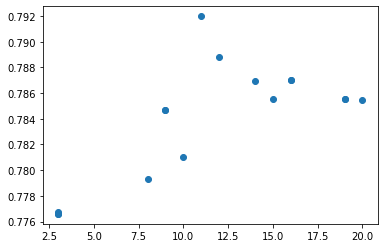

In [20]:
plt.scatter(k_all, scores_all)

## SVM

In [21]:
# KNN 과 동일 옵션만 바뀐 상태로 범위를 지정해주고 최적값을 탐색
SVM_search_point = {'k': (1,30), 'gamma': (0.001,20)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
gamma_all = []

def SVM_opt(k,gamma):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        SVMmodel = SVC( C= int(k) , kernel='rbf' , probability = True, gamma= gamma ) # SVM  
        
        SVMmodel2 = SVMmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = SVMmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    return np.mean(cvscores)

result = BayesianOptimization(SVM_opt, SVM_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=20, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |   gamma   |     k     |
-------------------------------------------------
|  1        |  0.7658   |  15.43    |  1.602    |
|  2        |  0.7752   |  9.991    |  15.67    |
|  3        |  0.7795   |  19.93    |  29.62    |
|  4        |  0.7646   |  0.2069   |  29.92    |
|  5        |  0.7768   |  7.662    |  1.622    |
|  6        |  0.4975   |  0.02341  |  1.678    |
|  7        |  0.7821   |  10.15    |  30.0     |
|  8        |  0.7833   |  18.04    |  3.379    |
|  9        |  0.7781   |  20.0     |  16.88    |
|  10       |  0.7847   |  12.97    |  8.226    |
|  11       |  0.4975   |  0.001    |  20.33    |
|  12       |  0.7797   |  14.8     |  23.27    |
|  13       |  0.7903   |  20.0     |  9.558    |
|  14       |  0.7803   |  19.63    |  1.074    |
|  15       |  0.7867   |  15.17    |  15.24    |
|  16       |  0.7728   |  5.225    |  29.98    |
|  17       |  0.7697   |  8.245    |  6.527    |
|  18       |  0.7794   |  20.0     |  24.09    |


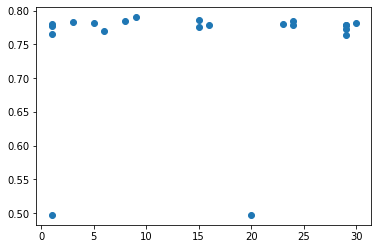

In [22]:
plt.scatter(k_all, scores_all)

## Decision Tree

In [23]:
DT_search_point = { 'k': (1,30), 'leaf' : ( 2, 30), 'split': (2,30) }

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all = []
split_all = []

def DT_opt(k,leaf,split):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        DTmodel = DecisionTreeClassifier(criterion='gini',
                                         max_depth=int(k), 
                                         min_samples_leaf= int(leaf),
                                         min_samples_split= int(split)) #DT  
        
        
        DTmodel2 = DTmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = DTmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    leaf_all.append(int(leaf))
    split_all.append(split)

    
    return np.mean(cvscores)

result = BayesianOptimization(DT_opt, DT_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |   leaf    |   split   |
-------------------------------------------------------------
|  1        |  0.7602   |  23.37    |  2.581    |  19.74    |
|  2        |  0.7217   |  26.25    |  23.01    |  19.33    |
|  3        |  0.7213   |  1.0      |  2.0      |  2.0      |
|  4        |  0.7213   |  1.0      |  2.0      |  30.0     |
|  5        |  0.7661   |  29.62    |  2.082    |  30.0     |
|  6        |  0.7773   |  29.69    |  2.631    |  3.316    |
|  7        |  0.7765   |  29.7     |  2.272    |  3.552    |
|  8        |  0.7401   |  2.168    |  29.91    |  2.629    |
|  9        |  0.7098   |  28.53    |  29.5     |  2.303    |
|  10       |  0.7213   |  1.857    |  28.42    |  29.14    |
|  11       |  0.7592   |  18.09    |  10.19    |  2.008    |
|  12       |  0.7631   |  29.78    |  8.381    |  9.739    |
|  13       |  0.7544   |  18.67    |  9.152    |  29.95    |
|  14       |  0.7643   |  29.61    |  6.568    |  2.002    |
|  15   

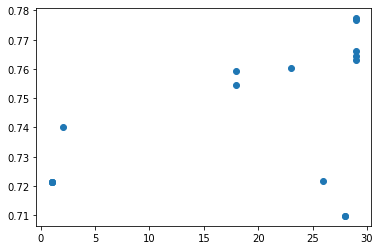

In [24]:
plt.scatter(k_all, scores_all)

## Random forest

In [25]:
RF_search_point = { 'k': (1,50), 'depth': (1,20) , 'leaf':(1,20), 'split':(2,20)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []

def RF_opt(k,depth,leaf,split):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        RFmodel = RandomForestClassifier( n_estimators= int(k),
                                         max_depth =int(depth), 
                                         min_samples_leaf= int(leaf),
                                         min_samples_split= int(split)) 
        
        
        RFmodel2 = RFmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = RFmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    
    return np.mean(cvscores)

result = BayesianOptimization(RF_opt, RF_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=20, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |   depth   |     k     |   leaf    |   split   |
-------------------------------------------------------------------------
|  1        |  0.7459   |  15.66    |  2.017    |  13.04    |  15.48    |
|  2        |  0.7619   |  5.371    |  10.31    |  9.909    |  4.388    |
|  3        |  0.7968   |  19.55    |  49.87    |  1.929    |  17.49    |
|  4        |  0.561    |  1.56     |  49.03    |  19.32    |  19.64    |
|  5        |  0.7515   |  20.0     |  50.0     |  20.0     |  2.0      |
|  6        |  0.7768   |  20.0     |  1.0      |  1.0      |  2.0      |
|  7        |  0.7864   |  20.0     |  50.0     |  1.0      |  2.0      |
|  8        |  0.8032   |  20.0     |  23.59    |  1.0      |  20.0     |
|  9        |  0.7493   |  20.0     |  14.77    |  20.0     |  2.0      |
|  10       |  0.794    |  16.68    |  23.72    |  2.968    |  19.32    |
|  11       |  0.5802   |  1.03     |  1.333    |  2.126    |  17.4     |
|  12       |  0.754    |  20.0     | 

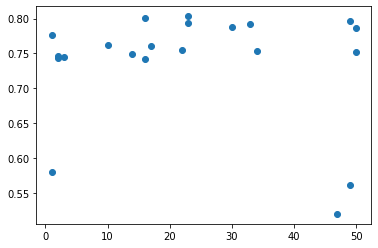

In [26]:
plt.scatter(k_all, scores_all)

# Voting ensemble
## 사용 된 모델 : KNN, SVM, Decision Tree, Logistic Regression

In [27]:
KNN_model = KNeighborsClassifier(n_neighbors = 11, weights = 'distance')

SVM_model = SVC( C= 10 , kernel='rbf' , probability = True , gamma = 20 )

DT_model = DecisionTreeClassifier(criterion='gini', max_depth=29, min_samples_leaf= 2, min_samples_split= 3)

RF_model = RandomForestClassifier( n_estimators= 20,min_samples_split = 2, min_samples_leaf= 6, max_depth=15)

In [28]:
ensemble=VotingClassifier(
        estimators=[('KNN',KNN_model),
                   ('SVM',SVM_model),
                   ('DT',DT_model),
                   ('RF',RF_model)]
        ,voting='soft')

# Voting 모델 안에 각 모델들을 묶어주기

In [29]:
KNN_model.fit(x_train,y_train)
SVM_model.fit(x_train,y_train)
DT_model.fit(x_train,y_train)
RF_model.fit(x_train,y_train)
ensemble.fit(x_train,y_train)

# 각 모델에  train 데이터 학습시키고
# 모델들이 묶어진 voting 앙상블에도 train 데이터를 학습

VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=11,
                                                   p=2, weights='distance')),
                             ('SVM',
                              SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=20, kernel='rbf', max_iter=-1,
                                  probability=True, random_...
                                                     criterion='gini',
                                                     max_depth=15,
       

# 교차검증 적용

In [30]:
SKF = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 16)

In [31]:
KNN_scores=cross_validate(KNN_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
SVM_scores=cross_validate(SVM_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
DT_scores=cross_validate(DT_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
RF_scores=cross_validate(RF_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
ensemble_scores=cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))

# 각 모델들의 성능 평가를 위해 교차검증 실시  확인할 score는 f1 임

In [32]:
print(KNN_scores)
print(SVM_scores)
print(DT_scores)
print(RF_scores)
print(ensemble_scores)

# validate 를 통해 모델 학습시간, 모델 가동시간, f1_score 를 확인 가능

{'fit_time': array([0.00439191, 0.00323987, 0.00182247, 0.00185943, 0.00236416]), 'score_time': array([0.00602674, 0.0049684 , 0.00316477, 0.00297427, 0.00377011]), 'test_score': array([0.7032967 , 0.7       , 0.79545455, 0.60674157, 0.75294118])}
{'fit_time': array([0.03798914, 0.03716135, 0.04162645, 0.03836799, 0.04202628]), 'score_time': array([0.00286102, 0.00282335, 0.00345469, 0.00282574, 0.00517607]), 'test_score': array([0.65263158, 0.64583333, 0.77083333, 0.64444444, 0.62650602])}
{'fit_time': array([0.00340128, 0.0036056 , 0.00321579, 0.00275993, 0.00302219]), 'score_time': array([0.00191832, 0.00225425, 0.0017426 , 0.00152683, 0.00151873]), 'test_score': array([0.73563218, 0.67368421, 0.69047619, 0.52380952, 0.69879518])}
{'fit_time': array([0.03379536, 0.03389382, 0.03425694, 0.03437161, 0.03376484]), 'score_time': array([0.0036602 , 0.00371647, 0.00386643, 0.00364733, 0.00366998]), 'test_score': array([0.75862069, 0.7032967 , 0.72093023, 0.75268817, 0.65789474])}
{'fit_ti

In [33]:
KNN_f1_score = KNN_scores["test_score"].mean()
SVN_f1_score = SVM_scores["test_score"].mean()
DT_f1_score = DT_scores["test_score"].mean()
RF_f1_score = RF_scores["test_score"].mean()
ensemble_f1_score = ensemble_scores["test_score"].mean()


print("f1_score: {0: .4f}".format(KNN_f1_score))
print("f1_score: {0: .4f}".format(SVN_f1_score))
print("f1_score: {0: .4f}".format(DT_f1_score))
print("f1_score: {0: .4f}".format(RF_f1_score))
print("f1_score: {0: .4f}".format(ensemble_f1_score))

# 나온 값들의 평균을 확인을 위해 mean 값을 print로 표시

f1_score:  0.7117
f1_score:  0.6680
f1_score:  0.6645
f1_score:  0.7187
f1_score:  0.6985


# test 데이터 예측 정확도

In [34]:
pred_KNN = KNN_model.predict(x_test)
pred_SVM = SVM_model.predict(x_test)
pred_DT = DT_model.predict(x_test)
pred_RF = RF_model.predict(x_test)

# 각 모델들의 test 데이터에 대한 예측 결과를 알기 위해 각각 예측실행

In [35]:
y_predict= ensemble.predict(x_test)

# 적용 모델인 Voting ensemble 예측

In [36]:
print('KNN',f1_score(y_test,pred_KNN))
print('SVM',f1_score(y_test,pred_SVM))
print('DT',f1_score(y_test,pred_DT))
print('RF',f1_score(y_test,pred_RF))
print('Voting',f1_score(y_test,y_predict))          # 각 모델들의 f1_Score 확인

KNN 0.7068965517241379
SVM 0.689655172413793
DT 0.6551724137931035
RF 0.7478260869565216
Voting 0.6902654867256638


# 2020 년 사고사례 데이터

In [38]:
from google.colab import files
uploaded = files.upload()

Saving 초량동 지형 강우량.xlsx to 초량동 지형 강우량.xlsx


In [41]:
import io
accident = pd.read_excel(io.BytesIO(uploaded["초량동 지형 강우량.xlsx"]))

In [43]:
#accident = pd.read_excel("초량동 지형 강우량.xlsx")   # 초량지하차도 지형정보 와 당일 시간당 강우량 데이터

In [42]:
Busanaccident = accident.drop(['SLOPE_L','SLOPE_H','FLOOD','MANHOLES_RATIO'], axis = 1)  # 불필요 컬럼제거
Busanaccidentclass = accident['FLOOD']                                                   # 종속 변수 

In [44]:
Busanaccident.rename(columns={'R_W_SUM':'Hourly_Rainfall_Weight','HOUR_RAINFALL':'Hourly_Rainfall','IMP_SUR_RATIO':'Impervious_Surface',
                              'IMP_W_SUM':'Impervious_Surface_Weight'},inplace=True)  
#가중치 적용을 위해 컬럼명 수정하여 사용

In [46]:
Busanaccident['SLOPE_AVG'] = Busanaccident['SLOPE_AVG'].astype(float)
Busanaccident['HIGH'] = Busanaccident['HIGH'].astype(float)

rain_weight = Busanaccident['Hourly_Rainfall'].copy()
imp_weight = Busanaccident['Impervious_Surface'].copy()
slope_weight = Busanaccident['SLOPE_AVG'].copy()
high_weight = Busanaccident['HIGH'].copy()

In [47]:
## 강우량 가중치

for idx,col in enumerate(Busanaccident['Hourly_Rainfall']):
    if col <= 15:
        rain_weight[idx] = col / (46)
    elif col > 15 and col <= 35:
        rain_weight[idx] = col / (18 * 2**2)
    elif col > 35 and col <= 60:
        rain_weight[idx] = col / (17 * 3**2)
    elif col > 60 and col <= 80:
        rain_weight[idx] = col / (11 * 4**2)
    elif col > 80:
        rain_weight[idx] = col / (6.28 * 5**2)

## 불투수면 가중치

for idx,col in enumerate(Busanaccident['Impervious_Surface']):
    if col <= 15:
        imp_weight[idx] = col / 6.66
    elif col > 15 and col <= 25:
        imp_weight[idx] = col / (20 * 2)
    elif col > 25 and col <= 40:
        imp_weight[idx] = col / (13.33 * 3)
    elif col > 40 and col <= 55:
        imp_weight[idx] = col / (33.33 * 4)
    elif col > 55:
        imp_weight[idx] = col / (26.67 * 5)

## 경사도 가중치

#Busanaccident['SLOPE_AVG_Weight'] = Busanaccident['SLOPE_AVG']

for idx,col in enumerate(Busanaccident['SLOPE_AVG']):
    if col <= 10:
        slope_weight[idx] = col / (41.67 / 5**2 )
    elif col > 10 and col <= 15:
        slope_weight[idx] = col / (25 / 4**2)
    elif col > 15 and col <= 25:
        slope_weight[idx] = col / (16.67 / 3**2)
    elif col > 25 and col <= 50:
        slope_weight[idx] = col / (8.33 / 2**2)
    elif col > 50:
        slope_weight[idx] = col / (8.33 / 1**2)

## 고도 가중치

#Busanaccident['HIGH_Weight'] = Busanaccident['HIGH']

for idx,col in enumerate(Busanaccident['HIGH']):
    if col <= 20:
        high_weight[idx] = col / (79.62 / 1**2)
    elif col > 20 and col <= 40:
        high_weight[idx] = col / (10.18 / 2**2)
    elif col > 40 and col <= 60:
        high_weight[idx] = col / (4.63 / 3**2)
    elif col > 60 and col <= 80:
        high_weight[idx] = col / (2.78 / 4**2)
    elif col > 80:
        high_weight[idx] = col / (2.78 / 5**2)

slope_weight

Busanaccident['Hourly_Rainfall_Weight'] = rain_weight
Busanaccident['Impervious_Surface_Weight'] = imp_weight
Busanaccident['SLOPE_AVG_Weight'] = slope_weight
Busanaccident['HIGH_Weight'] = high_weight


## 가중치 값을 구한뒤 불필요한 변수 다시 제거

Busanaccident = Busanaccident.drop(['SLOPE_AVG','Impervious_Surface','Hourly_Rainfall','HIGH'], axis = 1)

Busanaccident

Busanaccident = Busanaccident[['Hourly_Rainfall_Weight','Impervious_Surface_Weight','SLOPE_AVG_Weight','HIGH_Weight','F_WEIGHT','PUMP_RATIO']]

In [48]:
Busanaccident

,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight,F_WEIGHT,PUMP_RATIO
0,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
1,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
2,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
3,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
4,0.010870,0.434346,0.599952,0.050239,0.017,1.982160e-07
5,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
6,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07
7,0.021739,0.434346,0.599952,0.050239,0.017,1.982160e-07
8,0.076087,0.434346,0.599952,0.050239,0.017,1.982160e-07
9,0.000000,0.434346,0.599952,0.050239,0.017,1.982160e-07


## 정리된 데이터에 scale 적용

In [49]:
scaler = MinMaxScaler()
scaler.fit(Busanaccident)
Busanaccident = scaler.transform(Busanaccident)                         # sccler 적용

## 학습 데이터와 동일한 데이터 형태로 만들기위해 pca사용

In [50]:
pca = PCA(n_components=4)
printcipalComponents = pca.fit_transform(Busanaccident)
Busanaccident = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])

## 초량동에 대한 예측 실시


In [ ]:
accident_predict= ensemble.predict(Busanaccident)                       # 학습된 모델을 활용해 사고사례 예측 실시

In [ ]:
print(accident_predict)                                                 # 예측값 확인

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [ ]:
joblib.dump(ensemble, '../../Data/final_data/model/geo_model/ensemble.pkl')
joblib.dump(ensemble, '../../Web/ensemble.pkl')